In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

In [2]:
uploaded = files.upload()
data = pd.read_csv('H3.txt', sep = '\n')
print(data.head())

Saving H3.txt to H3.txt
                                            all_data
0                                     >iTELL-Chr1_61
1  CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...
2                                                  0
3                                   >iYAL067W-A_5085
4  AATTTTTATAGGTCGACCCTTCTGTCGCTTACTGGGTTGATTATCT...


In [3]:
all=data["all_data"].tolist()
cls=[]
sequence=[]
label=[]

In [4]:
length = len(all)
for i in range(length):
   if (i%3)==0:
             cls.append(all[i])
   else:
      if(all[i]== "0" or all[i]=="1"):
        label.append(all[i])
      else:
         sequence.append(all[i])

print(len(cls))
print(len(label))
print(len(sequence))

14965
14965
14965


In [5]:
df = pd.DataFrame(list(zip(cls, label, sequence)),
               columns =['classification' , 'label', 'sequence'])
df.head(10)

,classification,label,sequence
0,>iTELL-Chr1_61,0,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...
1,>iYAL067W-A_5085,0,AATTTTTATAGGTCGACCCTTCTGTCGCTTACTGGGTTGATTATCT...
2,>iYAL067W-A_6786,0,AATTATATTTCCATCAGCTCAATACCGCAGTACTTTGAAACCTGAT...
3,>iYAL067W-A_7060,0,AACAATAGTGGGTATGAGTAAAGATATATAGATCGATATTTTGAAT...
4,>YAL067C_SEO1_8061,1,CAAAGATTTCAACCATAGTAGGTATGCCCCAGATGAAACATTACTG...
5,>YAL067C_SEO1_8340,1,CACAATAGCGTCAATAATAAAGTTCCATCTCCATCCCTCTAAACCA...
6,>iYAL067C_9509,1,GTTTTTTTCCAGTGACACAATCTTTACCATTACACAGTTTTTACTA...
7,>iYAL067C_10442,0,CAGAAACATAAAATTATATCACTTTATTTCATATGGTTTCATGCTT...
8,>YAL065C_YAL065C_11570,1,AGATACCTCGAAACAAACTCTATGTAAACACTTATTTTATTGTGGT...
9,>iYAL064W-B_13286,1,ATGACTGGAGAAGAAGTGACTAGAGAAGAAGTGACTGAGGAAGAAA...


In [21]:
labels = list(df.loc[:,'label'])
print(type(labels))

<class 'list'>


In [22]:
sequences = list(df.loc[:, 'sequence'])
print(type(sequences))
seqqq=sequences

<class 'list'>


In [23]:
seqs = df.sequence.values


In [24]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in seqqq:
 
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())


In [25]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
max_length=500
input_features = sequence.pad_sequences(input_features, maxlen=max_length)


In [26]:
input_features = input_features.astype('float64')

In [12]:
#input_features= input_features.reshape(14965,2000)

In [27]:
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CACACCACAC ... GTTCTTCTAC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [28]:
labels = list(filter(None, label))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '1' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_features, input_labels, test_size=.25, random_state=42)


In [30]:
X_train.shape

(11223, 500, 4)

In [31]:
y_train.shape

(11223, 2)

In [53]:

from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(X_train.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 489, 32)           1568      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 122, 32)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3904)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                62480     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 34        
Total params: 64,082
Trainable params: 64,082
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

Epoch 1/15
88/88 [==============================] - 4s 46ms/step - loss: 0.0689 - binary_accuracy: 0.9882 - val_loss: 0.5919 - val_binary_accuracy: 0.8004
Epoch 2/15
88/88 [==============================] - 4s 46ms/step - loss: 0.0520 - binary_accuracy: 0.9922 - val_loss: 0.6151 - val_binary_accuracy: 0.8014
Epoch 3/15
88/88 [==============================] - 4s 46ms/step - loss: 0.0397 - binary_accuracy: 0.9948 - val_loss: 0.6519 - val_binary_accuracy: 0.8030
Epoch 4/15
88/88 [==============================] - 4s 46ms/step - loss: 0.0316 - binary_accuracy: 0.9962 - val_loss: 0.6862 - val_binary_accuracy: 0.8017
Epoch 5/15
88/88 [==============================] - 4s 46ms/step - loss: 0.0248 - binary_accuracy: 0.9976 - val_loss: 0.7137 - val_binary_accuracy: 0.7998
Epoch 6/15
88/88 [==============================] - 4s 46ms/step - loss: 0.0201 - binary_accuracy: 0.9979 - val_loss: 0.7373 - val_binary_accuracy: 0.8022
Epoch 7/15
88/88 [==============================] - 4s 46ms/step - los

In [60]:

from sklearn.metrics import accuracy_score


train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))


train-acc = 0.9988416644390983
test-acc = 0.7971672902191341


Confusion matrix:
 [[1407  419]
 [ 340 1576]]


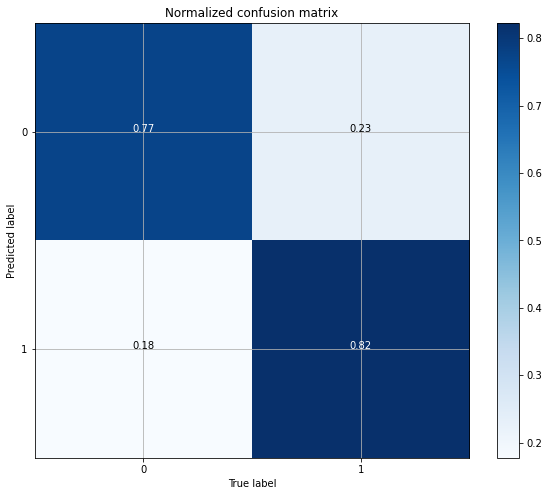

In [61]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


  **Plot Loss functions and model Accuracy¶**

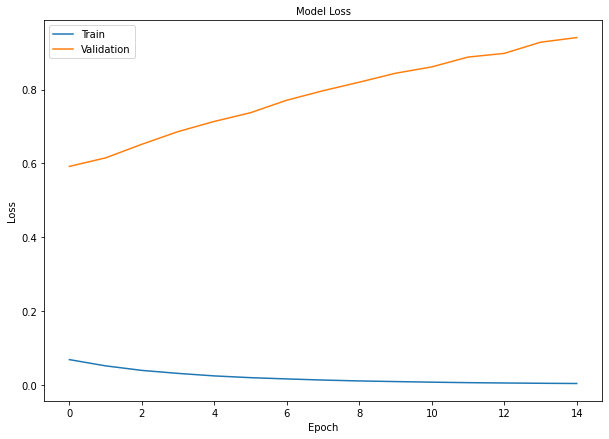

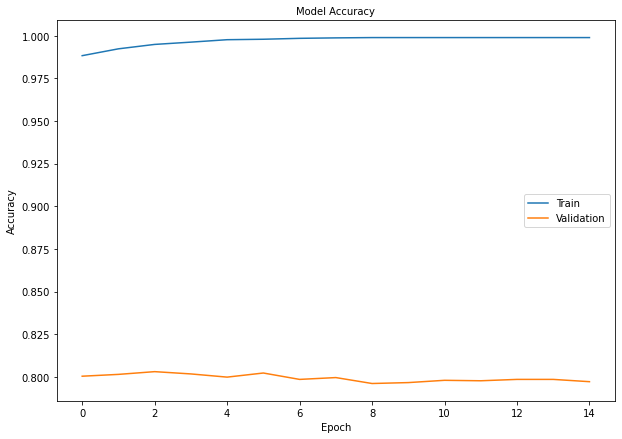

In [67]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.xlabel('Epoch', fontsize = 10)
plt.legend(['Train', 'Validation'], fontsize = 10)
plt.show()

plt.figure(figsize=(10,7))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.xlabel('Epoch', fontsize = 10)
plt.legend(['Train', 'Validation'], fontsize = 10)
plt.show()